In [1]:
#Libraries
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
from scipy.linalg import svd
import matplotlib.pyplot as plt


## Load and inspect data

In [2]:
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity = pd.read_csv('activity_train.csv', names=column_headers)

column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity_validation = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')

In [3]:
df_activity

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL207881,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [72]:
# Get unique pairs of Uniprot_IDs and ChEMBL_IDs from df_activity
unique_pairs_activity = set(zip(df_activity['Uniprot_IDs'], df_activity['ChEMBL_IDs']))

# Get unique pairs of Uniprot_IDs and ChEMBL_IDs from df_activity_validation
unique_pairs_validation = set(zip(df_activity_validation['Uniprot_IDs'], df_activity_validation['ChEMBL_IDs']))

# Find the intersection of unique pairs between df_activity and df_activity_validation
common_pairs = unique_pairs_activity.intersection(unique_pairs_validation)

# Count the number of common pairs
num_common_pairs = len(common_pairs)

if num_common_pairs > 0:
    print("Common pairs of Uniprot_IDs and ChEMBL_IDs between df_activity and df_activity_validation:")
    for pair in common_pairs:
        print(pair)
    print(f"Total number of common pairs: {num_common_pairs}")
else:
    print("There are no common pairs of Uniprot_IDs and ChEMBL_IDs between df_activity and df_activity_validation.")


Common pairs of Uniprot_IDs and ChEMBL_IDs between df_activity and df_activity_validation:
('O14842', 'CHEMBL207881')
Total number of common pairs: 1


In [4]:
# check if how many molecules activate on the same protein
df_activity.groupby('Uniprot_IDs')['ChEMBL_IDs'].nunique().sort_values(ascending=False)

Uniprot_IDs
P14416    8045
P29274    5578
P35462    5106
P30542    4812
P08908    4741
          ... 
Q8TDV5      48
P43220      48
Q96RJ0      44
P30550      44
P47211      40
Name: ChEMBL_IDs, Length: 144, dtype: int64

In [5]:
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [6]:
# check how many molecules in the test set are not in the training set
df_activity_validation[~df_activity_validation['ChEMBL_IDs'].isin(df_activity['ChEMBL_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [7]:
# check how many proteins in the test set are not in the training set
df_activity_validation[~df_activity_validation['Uniprot_IDs'].isin(df_activity['Uniprot_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [8]:
# print how many unique proteins and molecules are in the training set
print('Number of unique proteins in the training set:', df_activity['Uniprot_IDs'].nunique())
print('Number of unique molecules in the training set:', df_activity['ChEMBL_IDs'].nunique())

Number of unique proteins in the training set: 144
Number of unique molecules in the training set: 72631


In [9]:
# Get molecule information/non-latent features
mol_bits = pd.read_pickle('mol_bits.pkl')

#Create a sparse matrix with the mol_bits dataset and generate a subset for initial analysis

def create_sparse_matrix(data, num_rows):
    random.seed(42)  # Set a seed for reproducibility
    sampled_indices = random.sample(range(len(data)), num_rows)
    ChEMBL_IDs = [list(data.keys())[i] for i in sampled_indices]
    structural_features = [list(data.values())[i] for i in sampled_indices]

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(num_rows, num_features))
    
    return sparse_matrix, ChEMBL_IDs

sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits, len(mol_bits))
dense_matrix = sparse_matrix.toarray()

df_mol_bits = pd.DataFrame(dense_matrix, index=ChEMBL_IDs)
df_mol_bits

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL4586090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL292574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL3977929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL473197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL243694,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL146720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2113198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL552506,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL301416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# check if all molecules in df_activity have a fingerprint
df_activity[~df_activity['ChEMBL_IDs'].isin(df_mol_bits.index)]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [11]:
# 1. Step: Create user X items (molecules X proteins) matrix

# Define function
def create_interaction_matrix(df, molecule_col, protein_col, activity_col):
    interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')
    interactions = interactions.fillna(0)
    return interactions

# Create the interaction matrix
interactions = create_interaction_matrix(df_activity, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')

# Create the interaction matrix
interactions

Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Use a mask to hide the test set from the training set when training the model
def train_test_split_rectangle(interactions, test_ratio_items=0.2, test_ratio_users=0.2):
    # Determine the size of the test set for items and users separately
    num_molecules, num_proteins = interactions.shape
    num_test_items = int(test_ratio_items * num_proteins)
    num_test_users = int(test_ratio_users * num_molecules)
    print(f"Removing {num_test_items} items and {num_test_users} users from the bottom-right corner of the matrix for testing.")
    
    # Create train and test masks
    train_mask = np.ones(interactions.shape)
    test_mask = np.zeros(interactions.shape)
    
    # Indices for the test set (bottom-right corner)
    test_proteins_indices = range(num_proteins - num_test_items, num_proteins)
    test_molecules_indices = range(num_molecules - num_test_users, num_molecules)
    
    # Set the mask values
    for i in test_molecules_indices:
        for j in test_proteins_indices:
            train_mask[i, j] = 0
            test_mask[i, j] = 1
    
    # Apply the masks
    interaction_matrix = interactions.to_numpy()
    train_matrix = interaction_matrix * train_mask
    test_matrix = interaction_matrix * test_mask
    
    return train_matrix, test_matrix, train_mask, test_mask, interactions.index, interactions.columns

# Perform the train-test split
train_matrix, test_matrix, train_mask, test_mask, user_index, item_columns = train_test_split_rectangle(interactions, test_ratio_items=0.4, test_ratio_users=0.4)

# Convert matrices back to DataFrames for easier handling
train_df = pd.DataFrame(train_matrix, index=user_index, columns=item_columns)
test_df = pd.DataFrame(test_matrix, index=user_index, columns=item_columns)

# Print the shapes to verify
print(f"Train matrix shape: {train_df.shape}")
print(f"Test matrix shape: {test_df.shape}")

train_df

Removing 57 items and 29052 users from the bottom-right corner of the matrix for testing.
Train matrix shape: (72631, 144)
Test matrix shape: (72631, 144)


Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# just quickly check the masks -> working
print("Train Mask:")
display(train_mask)
print("Test Mask:")
display(test_mask)

Train Mask:


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Test Mask:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [14]:
# 2. Step: Apply SVD
U, sigma, Vt = svd(train_matrix, full_matrices=False)
U.shape

(72631, 144)

In [15]:
Vt.shape

(144, 144)

In [16]:
def make_init_PQ(U, S, Vt, k):
    # Extract the first k columns of U and Vt
    Uk = U[:, :k]  # Users x latent factors
    Sk = np.diag(S[:k])  # Create a diagonal matrix for the top k singular values
    Vk = Vt[:k, :]  # Latent factors x items
    
    # Compute P and Q matrices
    P = np.dot(Uk, Sk)  # P = U * Sigma
    Q = Vk  # Q = V.T
    return P, Q

k = 2
P, Q = make_init_PQ(U, sigma, Vt, k)

# Print the shapes of P and Q to verify
print(f"P shape: {P.shape}")
print(f"Q shape: {Q.shape}")

P shape: (72631, 2)
Q shape: (2, 144)


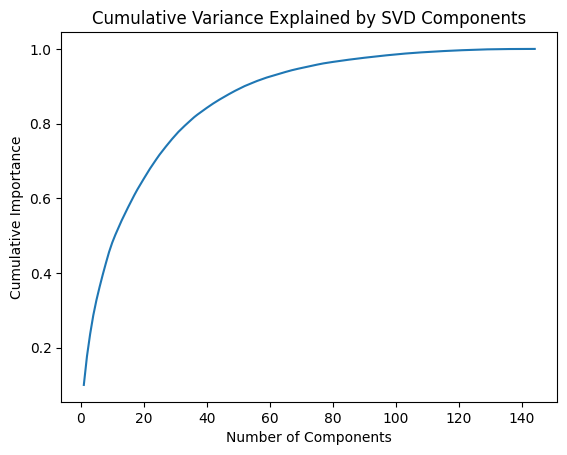

In [17]:
# Calculate cumulative variance explained from sigma for each k

variance_explained = sigma**2
total_variance = np.sum(variance_explained)

# Calculate cumulative importance
cumulative_importance = np.cumsum(variance_explained) / total_variance

# Create a DataFrame to display the results
df = pd.DataFrame({
    'k': np.arange(1, len(cumulative_importance) + 1),
    'Cumulative Importance': cumulative_importance
})

# plot the cumulative importance
plt.plot(df['k'], df['Cumulative Importance'])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Variance Explained by SVD Components')
plt.show()


In [18]:
# Function to create a mask for the observed ratings
def create_mask(matrix):
    return 1 * (matrix > 0)

# Function to calculate error using the precomputed mask and its sum
def calc_rmse(R, P, Q, mask, mask_sum):
    error = (R - np.dot(P, Q)) * mask
    return np.sqrt(np.sum(error**2) / mask_sum)

# Example usage with train and test matrices
train_mask = create_mask(train_matrix)
test_mask = create_mask(test_matrix)

train_mask_sum = np.sum(train_mask)
test_mask_sum = np.sum(test_mask)

# Calculate training error
train_error = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
print(f"Training RMSE: {train_error}")

# Calculate test error
test_error = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
print(f"Test RMSE: {test_error}")

Training RMSE: 4.850142648480755
Test RMSE: 5.861507605672985


In [19]:
# Regularized stochastic gradient descent
def run_epoch_reg(elems, R, P, Q, learning_rate, reg_p=1, reg_q=1):
    random.shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        delta = 2 * (r_ui - P[u, :] @ Q[:, i])
        P[u, :] += learning_rate * (delta * Q[:, i] - reg_p * P[u, :])
        Q[:, i] += learning_rate * (delta * P[u, :] - reg_q * Q[:, i])
    return P, Q

# Recommender SGD function
def recommender_sgd_reg(train_matrix, test_matrix, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    rated_elements = [(u, i) for u, i in np.argwhere(train_matrix > 0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q = run_epoch_reg(rated_elements, train_matrix, P, Q, learning_rate, reg_p, reg_q)
        train_rmse = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
        test_rmse = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if output_rmses == False:
        return P, Q
    else:
        return P, Q, train_rmses, test_rmses

k = 10
learning_rate = 0.001
num_epochs = 100
reg_p = 1
reg_q = 1

P,Q, train_rmses, test_rmses = recommender_sgd_reg(train_matrix, test_matrix, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, output_rmses=True)

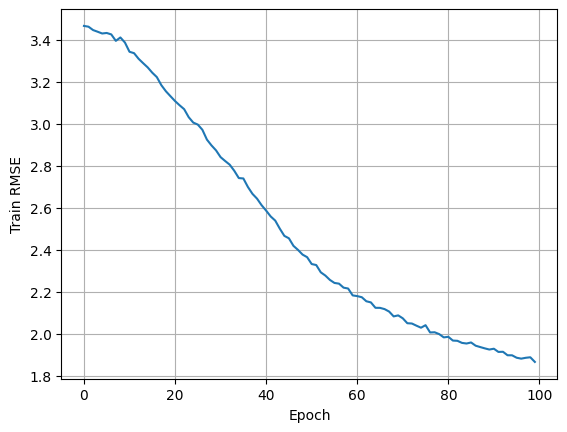

In [20]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

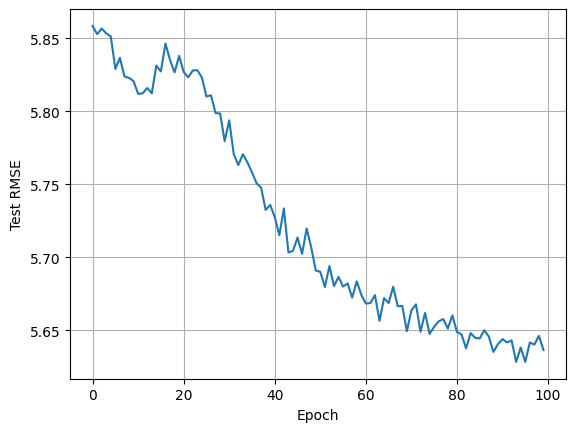

In [21]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

In [22]:
# Read csv, write results and write to csv
df_results = pd.read_csv('results.csv')

# Add the results to the DataFrame
# Create a DataFrame for the new data
new_data = pd.DataFrame([{
    'k_latent_factors': k,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'reg_p': reg_p,
    'reg_q': reg_q,
    'train_rmses': train_rmses,
    'test_rmses': test_rmses,
}])

# Concatenate the new data with the existing DataFrame
df_results = pd.concat([df_results, new_data], ignore_index=True)

# Remove duplicates
df_results = df_results.drop_duplicates(subset=['k_latent_factors', 'learning_rate', 'num_epochs', 'reg_p', 'reg_q'], keep='last')

df_results.to_csv('results.csv', index=False)
df_results

,k_latent_factors,learning_rate,reg_p,reg_q,train_rmses,test_rmses,num_epochs
0,10,0.001,1,1,"[3.5597096312433987, 3.5439419525305635, 3.527...","[4.427659609329391, 4.426449371106876, 4.41583...",200.0
2,5,0.001,1,1,"[3.743106006173365, 3.7400662591466434, 3.7198...","[6.3387843485272315, 6.338194958120992, 6.3379...",10.0
3,10,0.001,1,1,"[3.4662561156579645, 3.462580560298127, 3.4465...","[5.858511276938955, 5.852899306175715, 5.85671...",100.0


## Implement user features as bias and interaction

In [23]:
# prepare molecule fingerprints
desired_order = interactions.index
df_mol_bits_reindexed = df_mol_bits.reindex(desired_order)
df_mol_bits_reindexed

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100045,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL99983,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
CHEMBL99987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
molecule_features = df_mol_bits_reindexed.to_numpy()
print(molecule_features.shape)
molecule_features


(72631, 2048)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [25]:
# New error function to incorporate all information
def calc_rmse_complete(R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, mask, mask_sum):
    # Compute the user feature interactions
    t_u = user_features @ T  # Shape (num_users, k)
    d_u = user_features @ D  # Shape (num_users,)
    
    # Compute the predicted ratings
    R_pred = global_bias + item_biases + user_biases[:, np.newaxis] + d_u[:, np.newaxis] + (P + t_u) @ Q
    
    # Calculate the error
    error = (R - R_pred) * mask
    
    # Return RMSE
    return np.sqrt(np.sum(error**2) / mask_sum)

In [26]:
# Regularized stochastic gradient descent with biases and user features
def run_epoch_reg_complete(elems, R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1):
    random.shuffle(elems)
    for u, i in elems:
        # Get all matrices and vectors
        r_ui = R[u, i] # Actual prediction
        x_u = user_features[u, :] # Feature vector for user u
        q_i = Q[:, i] # Latent factors for item i
        p_u = P[u, :] # Latent factors for user u
        b_i = item_biases[i] # Bias for item i
        b_u = user_biases[u] # Bias for user u
        t_u = x_u @ T # User_features interaction term
        d_u = x_u @ D # User features bias term

        # get the prediction
        r_ui_pred = np.dot(q_i, p_u + t_u) + b_i + b_u + global_bias + d_u

        # Get delta
        delta = 2 * (r_ui - r_ui_pred)

        # Update parameters
        global_bias += learning_rate * delta
        b_i += learning_rate * (delta - reg_b * b_i)
        b_u += learning_rate * (delta - reg_b * b_u)
        P[u, :] += learning_rate * (delta * q_i - reg_p * p_u)
        Q[:, i] += learning_rate * (delta * (p_u + t_u) - reg_q * q_i)
        T += learning_rate * (delta * np.outer(x_u, q_i) - reg_t * T)
        D += learning_rate * (delta * x_u - reg_d * D)

    return P, Q, T, D, item_biases, user_biases, global_bias


In [27]:
# test adding the molecule features to !
# Initialize P and Q with SVD
U, S, V = svd(train_matrix, full_matrices=False)
P, Q = make_init_PQ(U, S, V, k)

# Recommender SGD function
def recommender_sgd_reg_complete(train_matrix, test_matrix, user_features, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    T = np.random.normal(scale=1./k, size=(user_features.shape[1], k))
    D = np.random.normal(scale=1./k, size=(user_features.shape[1],))
    item_biases = np.random.normal(scale=0.01, size=len(interactions.columns))
    user_biases = np.random.normal(scale=0.01, size=len(interactions.index))
    global_bias = np.mean(train_matrix[np.where(train_matrix != 0)])

    rated_elements = [(u, i) for u, i in np.argwhere(train_matrix > 0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q, T, D, item_biases, user_biases, global_bias = run_epoch_reg_complete(rated_elements, train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p, reg_q, reg_t, reg_d, reg_b)
        train_rmse = calc_rmse_complete(train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, train_mask, train_mask_sum)
        test_rmse = calc_rmse_complete(test_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, test_mask, test_mask_sum)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if output_rmses == False:
        return P, Q, T, D, item_biases, user_biases, global_bias
    else:
        return P, Q, T, D, item_biases, user_biases, global_bias, train_rmses, test_rmses

k = 2
learning_rate = 0.001
num_epochs = 100
reg_p = 1
reg_q = 1
reg_t = 1
reg_d = 1
reg_b = 1

P, Q, T, D, item_biases, user_biases, global_bias, train_rmses, test_rmses = recommender_sgd_reg_complete(train_matrix, test_matrix, molecule_features, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, reg_t=reg_t, reg_d=reg_d, reg_b=reg_b, output_rmses=True)

In [28]:
print(P.shape)
print(Q.shape)
print(T.shape)
print(D.shape)
print(item_biases.shape)
print(user_biases.shape)

(72631, 2)
(2, 144)
(2048, 2)
(2048,)
(144,)
(72631,)


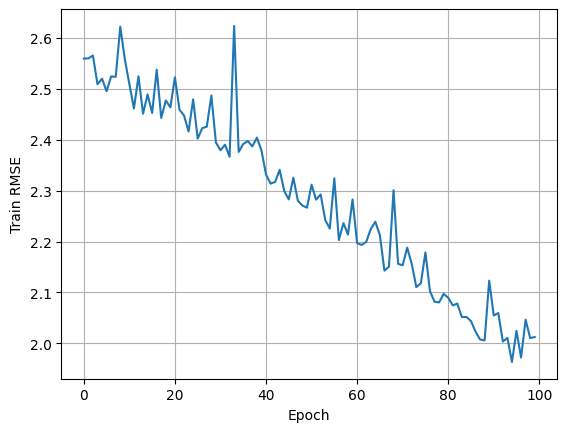

In [40]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

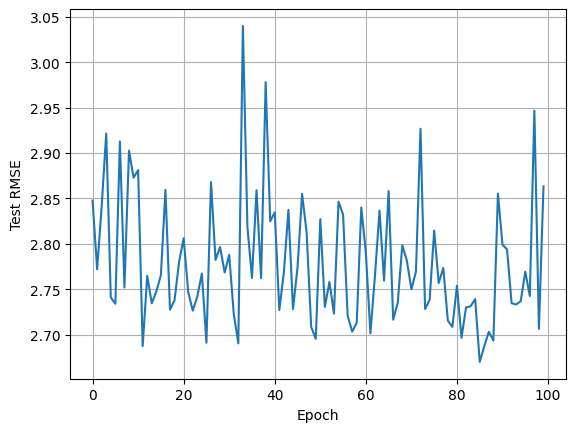

In [42]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

In [ ]:
# @TODO: Hyperparameter tuning -> see TP10 for inspiration

In [ ]:
# @TODO: Do a final run with the best hyperparameters on the full dataset and use these results for the final prediction

## Predicting on the blanked dataset

In [ ]:
# prediction set is already loaded as df_activity_validation
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [48]:
# Predict ratings for molecules that are already in our recommender system
def predict_rating(user_index, item_index, P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    # Get all matrices and vectors
    x_u = user_features[user_index, :]  # Feature vector for user u
    q_i = Q[:, item_index]  # Latent factors for item i
    p_u = P[user_index, :]  # Latent factors for user u
    b_i = item_biases[item_index]  # Bias for item i
    b_u = user_biases[user_index]  # Bias for user u
    t_u = x_u @ T  # User features interaction term
    d_u = x_u @ D  # User features bias term

    # Prediction
    r_ui_pred = q_i @ (p_u + t_u) + b_i + b_u + global_bias + d_u

    return r_ui_pred


def predict_ratings(user_item_pairs, P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    predictions = []
    for user_index, item_index in user_item_pairs:
        rating = predict_rating(user_index, item_index, P, Q, T, D, item_biases, user_biases, global_bias, user_features)
        predictions.append((user_index, item_index, rating))
    return predictions


In [49]:
# Code to calculate the predicted rating matrix in human-readable format
def compute_predicted_rating_matrix(P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    # Compute interaction terms
    t_u = user_features @ T
    d_u = user_features @ D
    
    # Compute predicted ratings matrix
    predicted_ratings = np.dot(P + t_u, Q) + item_biases + user_biases[:, np.newaxis] + global_bias + d_u[:, np.newaxis]
    
    return predicted_ratings

# Example usage:
# Assuming P, Q, T, D, item_biases, user_biases, global_bias, and user_features are already trained and available
predicted_rating_matrix = compute_predicted_rating_matrix(P, Q, T, D, item_biases, user_biases, global_bias, molecule_features)

# Convert the matrix to a DataFrame for better visualization
molecules_indices = range(user_biases.shape[0])
proteins_indices = range(144) 
predicted_rating_df = pd.DataFrame(predicted_rating_matrix, index=molecules_indices, columns=proteins_indices)

# Print the DataFrame
display(predicted_rating_df)

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,4.408030,3.229509,3.536900,3.908416,4.220659,5.463539,4.076470,4.137331,3.806863,3.524941,...,4.312789,3.858346,3.769566,4.680431,4.757231,3.684515,4.575453,5.106213,3.819670,5.114558
1,5.727831,4.027336,4.005777,4.943956,4.771663,7.457799,5.706204,6.021101,5.459671,4.522005,...,4.591576,4.890653,5.140165,6.032303,6.389739,4.310399,4.947007,7.313839,4.057183,6.890049
2,3.748293,2.903634,2.989395,3.372992,3.423046,4.555718,3.643368,3.747627,3.488373,3.138127,...,3.382227,3.341373,3.387151,3.910720,4.047788,3.123727,3.575335,4.416624,3.086441,4.297470
3,4.059155,2.928506,3.110322,3.564881,3.715322,5.118888,3.852334,3.964116,3.627248,3.229637,...,3.721724,3.521014,3.527718,4.296364,4.433861,3.274950,3.972195,4.869863,3.294011,4.772237
4,5.918425,3.959437,4.135813,5.041807,5.107392,7.829296,5.695424,5.964167,5.352266,4.497235,...,5.048961,4.973219,5.097154,6.313498,6.609655,4.445407,5.458868,7.494746,4.351361,7.194296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72626,5.798058,4.095511,3.891020,4.988888,4.574160,7.607746,5.956279,6.358734,5.764228,4.618920,...,4.263904,4.942461,5.340846,6.065043,6.524388,4.232895,4.615402,7.613754,3.801215,7.018453
72627,5.600254,4.205704,3.879961,4.916841,4.370422,7.145771,5.885722,6.288562,5.774488,4.660089,...,3.996656,4.884281,5.339211,5.783015,6.251780,4.192800,4.285955,7.284790,3.683092,6.649657
72628,5.763735,3.898529,3.885199,4.905072,4.728235,7.658995,5.729734,6.071405,5.456935,4.438825,...,4.541874,4.846500,5.111760,6.101524,6.485343,4.216768,4.929228,7.490386,3.950132,7.034969
72629,4.472200,3.259788,3.391945,3.933648,4.010665,5.636789,4.312090,4.462774,4.090059,3.591840,...,3.975754,3.889203,3.947380,4.714820,4.895238,3.580791,4.240800,5.419651,3.540837,5.256082


In [50]:

# Define function to create interaction matrix
def create_interaction_matrix(df, molecule_col, protein_col, activity_col):
    interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')
    interactions = interactions.fillna(0)
    return interactions


# Compute predicted rating matrix
predicted_rating_matrix = compute_predicted_rating_matrix(P, Q, T, D, item_biases, user_biases, global_bias, molecule_features)

# Create the interaction matrix from your dataset
interactions = create_interaction_matrix(df_activity, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')

# Get the indices (molecule IDs) and columns (protein IDs) from the interaction matrix
molecule_ids = interactions.index
protein_ids = interactions.columns

# Create the DataFrame for the predicted ratings with the same indices and columns
predicted_rating_df = pd.DataFrame(predicted_rating_matrix, index=molecule_ids, columns=protein_ids)

# Alternatively, display the DataFrame in a Jupyter Notebook
display(predicted_rating_df)

Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,4.408030,3.229509,3.536900,3.908416,4.220659,5.463539,4.076470,4.137331,3.806863,3.524941,...,4.312789,3.858346,3.769566,4.680431,4.757231,3.684515,4.575453,5.106213,3.819670,5.114558
CHEMBL1000,5.727831,4.027336,4.005777,4.943956,4.771663,7.457799,5.706204,6.021101,5.459671,4.522005,...,4.591576,4.890653,5.140165,6.032303,6.389739,4.310399,4.947007,7.313839,4.057183,6.890049
CHEMBL100003,3.748293,2.903634,2.989395,3.372992,3.423046,4.555718,3.643368,3.747627,3.488373,3.138127,...,3.382227,3.341373,3.387151,3.910720,4.047788,3.123727,3.575335,4.416624,3.086441,4.297470
CHEMBL100004,4.059155,2.928506,3.110322,3.564881,3.715322,5.118888,3.852334,3.964116,3.627248,3.229637,...,3.721724,3.521014,3.527718,4.296364,4.433861,3.274950,3.972195,4.869863,3.294011,4.772237
CHEMBL100045,5.918425,3.959437,4.135813,5.041807,5.107392,7.829296,5.695424,5.964167,5.352266,4.497235,...,5.048961,4.973219,5.097154,6.313498,6.609655,4.445407,5.458868,7.494746,4.351361,7.194296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,5.798058,4.095511,3.891020,4.988888,4.574160,7.607746,5.956279,6.358734,5.764228,4.618920,...,4.263904,4.942461,5.340846,6.065043,6.524388,4.232895,4.615402,7.613754,3.801215,7.018453
CHEMBL99983,5.600254,4.205704,3.879961,4.916841,4.370422,7.145771,5.885722,6.288562,5.774488,4.660089,...,3.996656,4.884281,5.339211,5.783015,6.251780,4.192800,4.285955,7.284790,3.683092,6.649657
CHEMBL99987,5.763735,3.898529,3.885199,4.905072,4.728235,7.658995,5.729734,6.071405,5.456935,4.438825,...,4.541874,4.846500,5.111760,6.101524,6.485343,4.216768,4.929228,7.490386,3.950132,7.034969


In [71]:
num_negative_values = (predicted_rating_df < 0).sum().sum()

print(f"There are {num_negative_values} negative values in the predicted_rating_df DataFrame.")

There are 95994 negative values in the predicted_rating_df DataFrame.


In [101]:
#Check partiular pairs of molecules and proteins predicted activity
uniprot_id = 'O14842'
chembl_id = 'CHEMBL207881'

# Check if the Uniprot_ID and ChEMBL_ID are present in the DataFrame
if chembl_id in predicted_rating_df.index and uniprot_id in predicted_rating_df.columns:
    predicted_rating = predicted_rating_df.at[chembl_id, uniprot_id]
    print(f"Predicted rating for {chembl_id} and {uniprot_id} is {predicted_rating}")
else:
    print(f"No predicted rating found for {chembl_id} and {uniprot_id}")

Predicted rating for CHEMBL207881 and O14842 is 4.559321438241954


In [66]:
def get_predicted_rating(uniprot_id, chembl_id):
    if chembl_id in predicted_rating_df.index and uniprot_id in predicted_rating_df.columns:
        return predicted_rating_df.at[chembl_id, uniprot_id]
    else:
        return None  # or some default value like 0

# Update the 'Activity' column in df_activity_validation
df_activity_validation['Activity'] = df_activity_validation.apply(
    lambda row: get_predicted_rating(row['Uniprot_IDs'], row['ChEMBL_IDs']), axis=1
)

# Print the updated df_activity_validation
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,NaN
1,O14842,CHEMBL2047161,NaN
2,O14842,CHEMBL2047163,NaN
3,O14842,CHEMBL2047168,NaN
4,O14842,CHEMBL2047169,NaN
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,NaN
4624,Q9Y5Y4,CHEMBL4205421,NaN
4625,Q9Y5Y4,CHEMBL4207935,NaN
4626,Q9Y5Y4,CHEMBL4208884,NaN


In [67]:
df_activity_validation['Activity'] = df_activity_validation['Activity'].apply(lambda x: '' if pd.isna(x) else max(0, round(x)))

# Print the updated DataFrame
print(df_activity_validation)

     Uniprot_IDs     ChEMBL_IDs Activity
0         O14842  CHEMBL2022258         
1         O14842  CHEMBL2047161         
2         O14842  CHEMBL2047163         
3         O14842  CHEMBL2047168         
4         O14842  CHEMBL2047169         
...          ...            ...      ...
4623      Q9Y5Y4  CHEMBL4208314         
4624      Q9Y5Y4  CHEMBL4205421         
4625      Q9Y5Y4  CHEMBL4207935         
4626      Q9Y5Y4  CHEMBL4208884         
4627      Q9Y5Y4  CHEMBL4205802         

[4628 rows x 3 columns]


In [69]:
#df_activity_validation.to_csv('updated_activity_validation.csv', index=False)

In [125]:
empty_activity_rows = df_activity_validation[df_activity_validation['Activity'] == '']

# Create a new DataFrame with only the empty activity rows
df_empty_activity = empty_activity_rows.copy()


# Print the new DataFrame
df_empty_activity 

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,
1,O14842,CHEMBL2047161,
2,O14842,CHEMBL2047163,
3,O14842,CHEMBL2047168,
4,O14842,CHEMBL2047169,
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,
4624,Q9Y5Y4,CHEMBL4205421,
4625,Q9Y5Y4,CHEMBL4207935,
4626,Q9Y5Y4,CHEMBL4208884,


In [216]:
df_empty_activity  = pd.read_csv('df_empty_activity.csv')
df_empty_activity 

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
1245,Q9Y5Y4,CHEMBL4208314,0
1246,Q9Y5Y4,CHEMBL4205421,0
1247,Q9Y5Y4,CHEMBL4207935,0
1248,Q9Y5Y4,CHEMBL4208884,0


In [196]:
activity_train = pd.read_csv('activity_train.csv', header=None)
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
activity_train = pd.read_csv('activity_train.csv', names=column_headers)

activity_test_blanked = pd.read_csv('activity_test_blanked.csv', header=None)
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
activity_test_blanked = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')

In [197]:
def create_sparse_matrix(data):
    ChEMBL_IDs = list(data.keys())
    structural_features = list(data.values())

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(ChEMBL_IDs), num_features))
    
    return sparse_matrix, ChEMBL_IDs

In [198]:
sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits)
dense_matrix_full = sparse_matrix.toarray()
dense_matrix_full

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [199]:
df_sparse_matrix = pd.DataFrame(dense_matrix_full, index=ChEMBL_IDs)

In [202]:
df_sparse_matrix

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL2022243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CHEMBL2022247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4218012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL4217503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4205802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CHEMBL4204359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [200]:
from sklearn.metrics import jaccard_score

In [217]:
df_empty_activity 

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
1245,Q9Y5Y4,CHEMBL4208314,0
1246,Q9Y5Y4,CHEMBL4205421,0
1247,Q9Y5Y4,CHEMBL4207935,0
1248,Q9Y5Y4,CHEMBL4208884,0


In [218]:
def find_most_similar_molecule(df_empty_activity, df_sparse_matrix):
   results = []
  for index, row in df_empty_activity.iterrows():
    chemble_id = row['ChEMBL_IDs']
    # Check if ChEMBL_ID exists in df_sparse_matrix
    if chemble_id not in df_sparse_matrix.index:
      most_similar = "NA"
      jaccard_similarity = 0
    else:
      molecule_vector = df_sparse_matrix.loc[chemble_id]
      max_similarity = 0
      most_similar_chemble_id = None
      for other_chemble_id, other_vector in df_sparse_matrix.iterrows():
        if other_chemble_id == chemble_id:
          continue  # Skip comparing the molecule to itself
        intersection = (molecule_vector & other_vector).sum()
        union = (molecule_vector | other_vector).sum()
        jaccard_score = intersection / union if union > 0 else 0
        if jaccard_score > max_similarity:
          max_similarity = jaccard_score
          most_similar_chemble_id = other_chemble_id
      most_similar = most_similar_chemble_id
      jaccard_similarity = max_similarity

    results.append({
        "Original Molecule": chemble_id,
        "Most Similar Molecule": most_similar,
        "Jaccard Similarity": jaccard_similarity
    })

  return pd.DataFrame(results)

In [219]:
result_df = find_most_similar_molecule(df_empty_activity, df_sparse_matrix)


KeyboardInterrupt: 

In [ ]:
result_df

In [215]:
result_df

,Original Molecule,Most Similar Molecule,Jaccard Similarity
0,CHEMBL2022258,CHEMBL2022247,0.825000
1,CHEMBL2047161,CHEMBL2047154,0.797980
2,CHEMBL2047163,CHEMBL2022576,0.675926
3,CHEMBL2047168,CHEMBL2047169,0.779817
4,CHEMBL2047169,CHEMBL2047168,0.779817
5,CHEMBL2048621,CHEMBL2048618,0.656863
6,CHEMBL2048623,CHEMBL2048619,0.782609
7,CHEMBL4067052,CHEMBL4078852,0.690141
8,CHEMBL4069191,CHEMBL4073525,0.729412
